## 1. Setup

### 1.1 Install nVidia CUDA
The following installation steps available at: https://developer.nvidia.com/cuda-downloads

wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64/cuda-ubuntu2404.pin <br>
sudo mv cuda-ubuntu2404.pin /etc/apt/preferences.d/cuda-repository-pin-600 <br>
get https://developer.download.nvidia.com/compute/cuda/12.6.2/local_installers/cuda-repo-ubuntu2404-12-6-local_12.6.2-560.35.03-1_amd64.deb <br>
sudo dpkg -i cuda-repo-ubuntu2404-12-6-local_12.6.2-560.35.03-1_amd64.deb <br>
sudo cp /var/cuda-repo-ubuntu2404-12-6-local/cuda-*-keyring.gpg /usr/share/keyrings/ <br>
sudo apt-get update <br>
sudo apt-get -y install cuda-toolkit-12-6 <br>

<strong>Note:</strong> CUDA must be installed before cuDNN as cuDNN builds upon CUDA and uses its interface during installation.

### 1.2 Install nVidia cuDNN
The following installation steps are also available at: https://developer.nvidia.com/cudnn-downloads

wget https://developer.download.nvidia.com/compute/cudnn/9.5.0/local_installers/cudnn-local-repo-ubuntu2404-9.5.0_1.0-1_amd64.deb <br>
sudo dpkg -i cudnn-local-repo-ubuntu2404-9.5.0_1.0-1_amd64.deb <br>
sudo cp /var/cudnn-local-repo-ubuntu2404-9.5.0/cudnn-*-keyring.gpg /usr/share/keyrings/ <br>
sudo apt-get update <br>
sudo apt-get -y install cudnn <br>

### 1.3 Install TensorRT (optional)
The following installation steps are also available at: https://pypi.org/project/tensorrt-cu12/ <br>
More details can be found at: https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html

pip install tensorrt --extra-index-url https://pypi.nvidia.com <br>

### 1.4 Install libraries
Install the required libraries in the following order: <br>
pandas: pip install pandas  
matplotlib: pip install matplotlib <br>
tensorflow: pip install tensorflow[and-cuda] <br>

In [2]:
# local custom libs
from classifiers import System
from classifiers.image import Sampler, BinaryClassifier

# built-in libs
import os
from os.path import join

# third party libs
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import mixed_precision
from keras.utils import to_categorical, image_dataset_from_directory

# plots will be printed in the notebook
%matplotlib inline

# Enable mixed precision for faster training during experiments
# mixed_precision.set_global_policy('mixed_float16')

System.print_info()

Info: Environment variable 'KERAS_BACKEND' set to 'tensorflow'
Info: Environment variable 'TF_CPP_MIN_LOG_LEVEL' set to '1'
System Information:
-------------------
Keras Backend: tensorflow
Tensorflow log level: 1
CPUs Available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
-------------------


### 2.1.1 Reference model

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
----------------------------------------
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5104 - loss: 27.9473 - val_accuracy: 0.5040 - val_loss: 0.8291
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5622 - loss: 0.7791 - val_accuracy: 0.5090 - val_loss: 1.1249
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6315 - loss: 0.6968 - val_accuracy: 0.6240 - val_loss: 0.7205
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6915 - loss: 0.6086 - val_accuracy: 0.6770 - val_loss: 0.6608
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7898 - loss: 0.4456 - val_accuracy: 0.6460 - val_loss: 0.7267
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8663 - loss: 0.3291 - val_accuracy: 0.6660 - val_loss: 0.7643
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accura

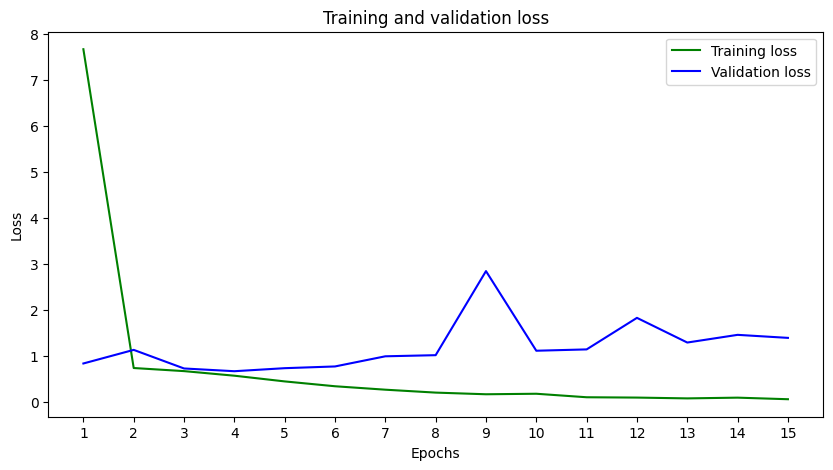

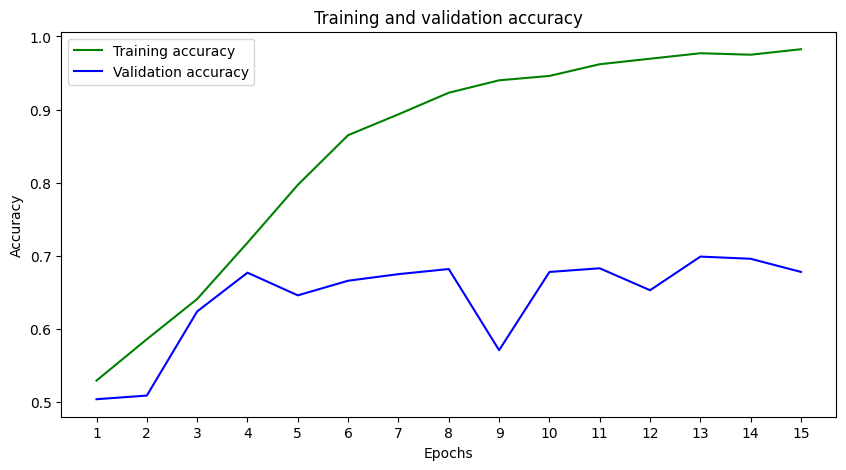

In [4]:
# hyperparameters
batch_size = 20
n_epochs = 15

# data sampling
train_generator = image_dataset_from_directory(
    os.path.join('data', 'dogs_cats', 'train'),
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='binary'
).repeat()  # Ensures dataset repetition every epoch

validation_generator = image_dataset_from_directory(
    os.path.join('data', 'dogs_cats', 'validation'),
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='binary'
).repeat()  # Ensures dataset repetition every epoch

test_generator = image_dataset_from_directory(
    os.path.join('data', 'dogs_cats', 'test'),
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='binary'
).repeat()  # Ensures dataset repetition every epoch

print('----------------------------------------')

# initilaize new CNN model
model_ref = models.Sequential()

# input layer for 150x150 RGB images, hence 3 channels
model_ref.add(layers.Input(shape=(150, 150, 3))) 

# recognizes small local patterns
model_ref.add(layers.Conv2D(32, (3, 3), activation='relu')) 
model_ref.add(layers.MaxPooling2D((2, 2)))

# recognizes larger patterns from prev layer
model_ref.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model_ref.add(layers.MaxPooling2D((2, 2)))

# recognizes larger patterns from prev layer
model_ref.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model_ref.add(layers.MaxPooling2D((2, 2)))

# recognizes larger patterns from prev layer
model_ref.add(layers.Conv2D(256, (3, 3), activation='relu')) 

# since the prev layer outputs 3D feature maps (height, width, features)
# and dense layers work with 1D tensors, the output must be flattened
# (3D feature maps) before passign it into a dense layer
model_ref.add(layers.Flatten())

# some dropout to prevent overfitting
model_ref.add(layers.Dropout(0.5))

# now adding dense layers for classification
model_ref.add(layers.Dense(512, activation='relu'))
model_ref.add(layers.Dense(1, activation='sigmoid')) # only 2 categories

# compile the model 
model_ref.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model_ref.fit(
    train_generator,
    steps_per_epoch=2000 // batch_size,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=1000 // batch_size
)

model_path = join('models', 'dogs_cats', 'referential.keras')
model_ref.save(model_path)
print('Model saved to:', model_path)

# evaluate the model in terms training and validation loss
test_loss, test_acc = model_ref.evaluate(test_generator, steps=50)
print('Test loss:', round(test_loss, 4), 'Test accuracy:', round(test_acc, 4))

history_loss = history.history['loss']
history_val_loss = history.history['val_loss']
epochs=range(1, len(history_loss) + 1)
plot_size = (10, 5)

plt.figure(figsize=plot_size)
plt.plot(epochs, history_loss, 'g', label='Training loss')
plt.plot(epochs, history_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

# evaluate the model in terms of accuracy and loss
history_accuracy = history.history['accuracy']
history_val_accuracy = history.history['val_accuracy']

plt.figure(figsize=plot_size)
plt.plot(epochs, history_accuracy, 'g', label='Training accuracy')
plt.plot(epochs, history_val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()

### 2.2.1 VGG model - Data sampling

Found 2000 files belonging to 2 classes.


I0000 00:00:1730368780.341443    6875 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2172 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
----------------------------------------
Epoch 1/100


I0000 00:00:1730368783.322860    6978 service.cc:148] XLA service 0x74ec88007250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730368783.323365    6978 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-10-31 10:59:43.372001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730368783.577952    6978 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1730368795.727884    6978 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 159ms/step - accuracy: 0.4723 - loss: 0.7408 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - accuracy: 0.4961 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.5063 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.5048 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6890
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.5274 - loss: 0.6976 - val_accuracy: 0.5130 - val_loss: 0.6866
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.5293 - loss: 0.6962 - val_accuracy: 0.5740 - val_loss: 0.6880
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.5395 - loss: 0.6910 - val_accuracy: 0.5350 - val_loss: 0.6888
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 148ms/step - accuracy: 0.5570 - loss: 0.687

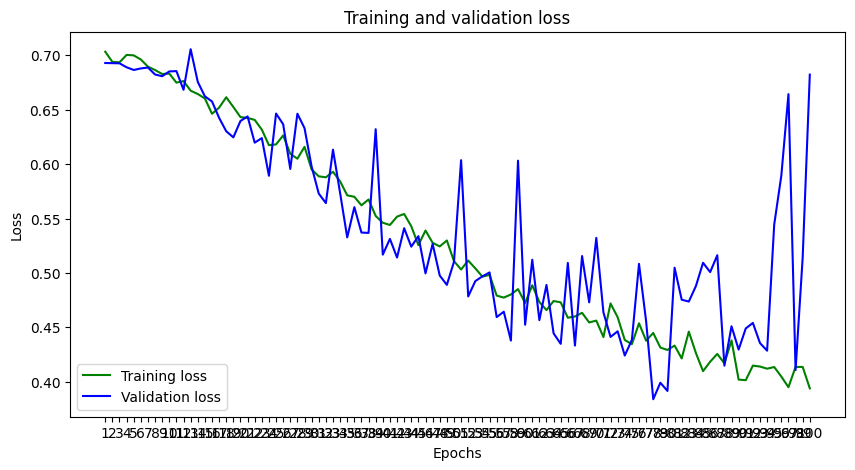

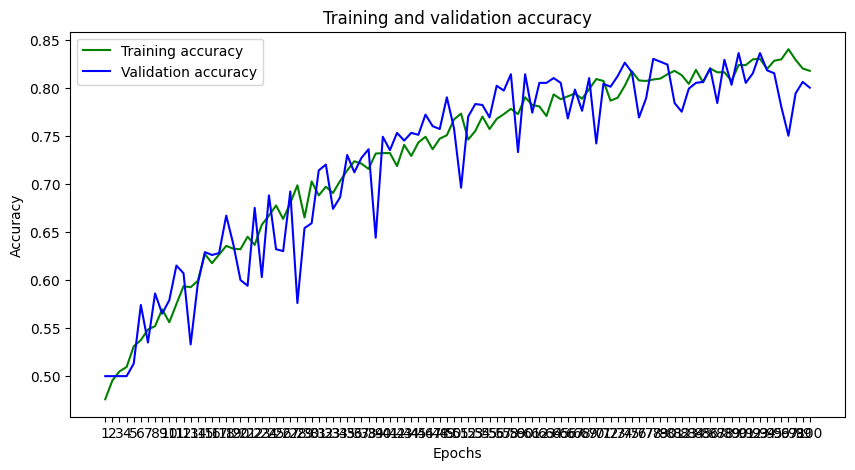

In [ ]:
from tensorflow.keras import layers, models, optimizers, callbacks

batch_size = 10
n_epochs = 150

# data sampling
train_generator = image_dataset_from_directory(
    os.path.join('data', 'dogs_cats', 'train'),
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='binary'
).repeat()  # Ensures dataset repetition every epoch

validation_generator = image_dataset_from_directory(
    os.path.join('data', 'dogs_cats', 'validation'),
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='binary'
).repeat()  # Ensures dataset repetition every epoch

test_generator = image_dataset_from_directory(
    os.path.join('data', 'dogs_cats', 'test'),
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='binary'
).repeat()  # Ensures dataset repetition every epoch

# Define image augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),        # Random horizontal flip
    layers.RandomRotation(0.2),             # Randomly rotate images by 20%
    layers.RandomZoom(0.2),                 # Randomly zoom in/out by 20%
    layers.RandomTranslation(0.2, 0.2),     # Randomly translate images
    layers.RandomContrast(0.2)              # Randomly change contrast
])

# Apply the data augmentation to the training dataset
train_dataset = train_generator.map(
    # Apply augmentations only during training
    lambda x, y: (data_augmentation(x, training=True), y),  
    num_parallel_calls=tf.data.AUTOTUNE
)


print('----------------------------------------')

# initilaize new CNN model
model_vgg = models.Sequential()

# input layer for 150x150 RGB images, hence 3 channels
model_vgg.add(layers.Input(shape=(150, 150, 3))) 

# recognizes small local patterns
model_vgg.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_vgg.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.MaxPooling2D((2, 2)))

# recognizes larger patterns from prev layer
model_vgg.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.MaxPooling2D((2, 2)))

# recognizes larger patterns from prev layer
model_vgg.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.MaxPooling2D((2, 2)))

# recognizes larger patterns from prev layer
model_vgg.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.MaxPooling2D((2, 2)))

# recognizes larger patterns from prev layer
model_vgg.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same')) 
model_vgg.add(layers.MaxPooling2D((2, 2)))

# the model so far outputs 3D feature maps (height, width, features);
# dense layers work with 1D tensors so flatten
# the output (3D feature maps) of the last layer
model_vgg.add(layers.Flatten())

model_vgg.add(layers.Dropout(0.3))

# now adding dense layers for classification
model_vgg.add(layers.Dense(512, activation='relu'))
model_vgg.add(layers.Dense(256, activation='relu'))
model_vgg.add(layers.Dense(1, activation='sigmoid')) # only 2 categories


# compile the model 
model_vgg.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# train the model
history = model_vgg.fit(
    train_dataset,
    steps_per_epoch=2000 // batch_size,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=1000 // batch_size
)

model_path = join('models', 'dogs_cats', 'vgg.keras')
model_vgg.save(model_path)
print('Model saved to:', model_path)

# evaluate the model in terms training and validation loss
test_loss, test_acc = model_vgg.evaluate(test_generator, steps=50)
print('Test loss:', round(test_loss, 4), 'Test accuracy:', round(test_acc, 4))

history_loss = history.history['loss']
history_val_loss = history.history['val_loss']
epochs=range(1, len(history_loss) + 1)
plot_size = (14, 5)

plt.figure(figsize=plot_size)
plt.plot(epochs, history_loss, 'g', label='Training loss')
plt.plot(epochs, history_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xticks(epochs)
plt.legend()
plt.show()

# evaluate the model in terms of accuracy and loss
history_accuracy = history.history['accuracy']
history_val_accuracy = history.history['val_accuracy']

plt.figure(figsize=plot_size)
plt.plot(epochs, history_accuracy, 'g', label='Training accuracy')
plt.plot(epochs, history_val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.xticks(epochs)
plt.legend()
plt.show()

# Test loss: 0.607 Test accuracy: 0.734

### 2.3.1 Augmented model - Data sampling

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
----------------------------------------
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5130 - loss: 14.8281 - val_accuracy: 0.5380 - val_loss: 0.6889
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5205 - loss: 0.7780 - val_accuracy: 0.5440 - val_loss: 0.6951
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5247 - loss: 0.7360 - val_accuracy: 0.5400 - val_loss: 0.6845
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5617 - loss: 0.7166 - val_accuracy: 0.5930 - val_loss: 0.6736
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6028 - loss: 0.6818 - val_accuracy: 0.5860 - val_loss: 0.6785
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5685 - loss: 0.6905 - val_accuracy: 0.5800 - val_loss: 0.6757
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step -

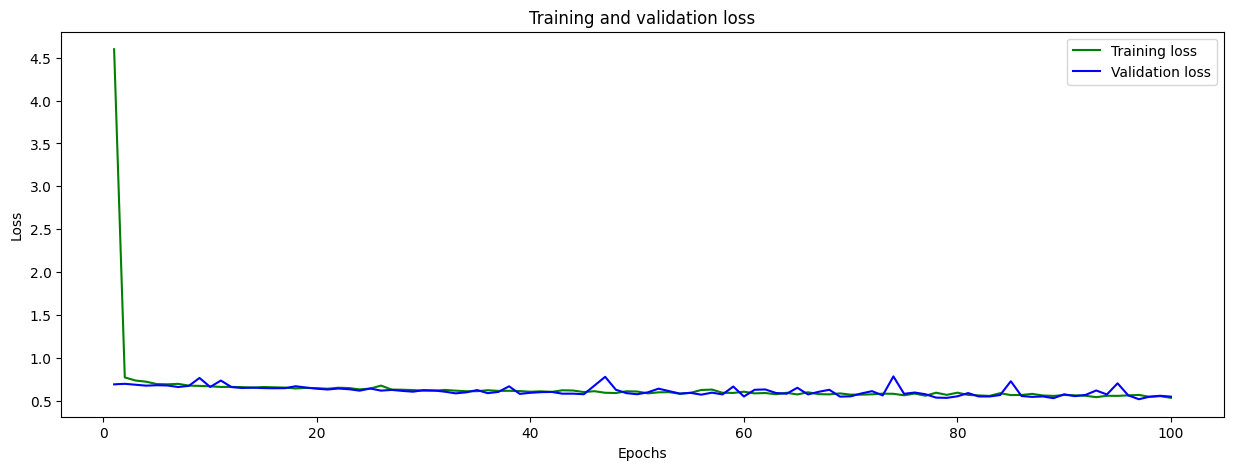

<Figure size 640x480 with 0 Axes>

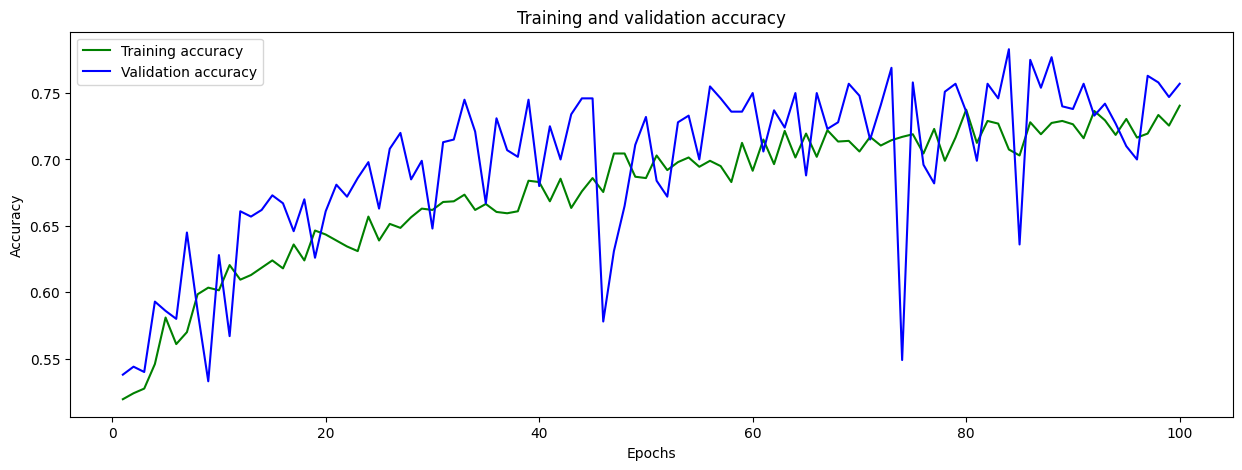

In [7]:
# hyperparameters
batch_size = 20
n_epochs = 100

# data sampling
train_generator = image_dataset_from_directory(
    os.path.join('data', 'dogs_cats', 'train'),
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='binary'
).repeat()  # Ensures dataset repetition every epoch

validation_generator = image_dataset_from_directory(
    os.path.join('data', 'dogs_cats', 'validation'),
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='binary'
).repeat()  # Ensures dataset repetition every epoch

test_generator = image_dataset_from_directory(
    os.path.join('data', 'dogs_cats', 'test'),
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='binary'
).repeat()  # Ensures dataset repetition every epoch

# Define image augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),        # Random horizontal flip
    layers.RandomRotation(0.2),             # Randomly rotate images by 20%
    layers.RandomZoom(0.2),                 # Randomly zoom in/out by 20%
    layers.RandomTranslation(0.2, 0.2),     # Randomly translate images
    layers.RandomContrast(0.2)              # Randomly change contrast
])

# Apply the data augmentation to the training dataset
train_dataset = train_generator.map(
    # Apply augmentations only during training
    lambda x, y: (data_augmentation(x, training=True), y),  
    num_parallel_calls=tf.data.AUTOTUNE
)


print('----------------------------------------')

# initilaize new CNN model
# for image classifcation
model_aug = models.Sequential()
model_aug.add(layers.Input(shape=(150, 150, 3))) # RGB images, hence 3 channels
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu')) # recognizes small local patterns
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Conv2D(64, (3, 3), activation='relu')) # recognizes larger patterns from prev layer
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Conv2D(128, (3, 3), activation='relu')) # recognizes larger patterns from prev layer
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Conv2D(128, (3, 3), activation='relu')) # recognizes larger patterns from prev layer

# since the prev layer outputs 3D feature maps (height, width, features)
# and dense layers work with 1D tensors, the output must be flattened
# (3D feature maps) before passign it into a dense layer
model_aug.add(layers.Flatten())

# Randomly set 50% of input units to zero during training to help
# the model learn more robust features and improve generalization.
model_aug.add(layers.Dropout(0.5))

# now adding dense layers for classification
model_aug.add(layers.Dense(512, activation='relu'))
model_aug.add(layers.Dense(1, activation='sigmoid')) # only 2 categories

# compile the model 
model_aug.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']    
)

# start training the model
history = model_aug.fit(
    train_dataset,
    steps_per_epoch=2000 // batch_size,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=1000 // batch_size
)


model_path = join('models', 'dogs_cats', 'augmented.keras')
model_aug.save(model_path)
print('Model saved to:', model_path)

# evaluate the model in terms of accuracy and loss
test_loss, test_acc = model_aug.evaluate(test_generator, steps=50)
print('Test loss:', round(test_loss, 4), 'Test accuracy:', round(test_acc, 4))

history_loss = history.history['loss']
history_val_loss = history.history['val_loss']
epochs=range(1, len(history_loss) + 1)

plt.figure(figsize=(15, 5))
plt.plot(epochs, history_loss, 'g', label='Training loss')
plt.plot(epochs, history_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# clear prev plot
plt.clf()

history_accuracy = history.history['accuracy']
history_val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(15, 5))
plt.plot(epochs, history_accuracy, 'g', label='Training accuracy')
plt.plot(epochs, history_val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
def read_image(img_path) -> np.ndarray:
    
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0
    
    return img_tensor

model_path = join('models', 'dogs_cats', 'vgg.keras')
model = models.load_model(model_path)

cat_img_path = os.path.join('data', 'dogs_cats', 'test', 'cats', '20.jpg')
dog_img_path = os.path.join('data', 'dogs_cats', 'test', 'dogs', '35.jpg')

cat_img = read_image(cat_img_path)
dog_img = read_image(dog_img_path)

prediction = model.predict(cat_img)
print(prediction[0][0])
prediction = model.predict(dog_img) 
print(prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
0.018265339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.020524438
